In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from scipy.stats import linregress
from scipy import interpolate

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = ds.LON[jmin:jmax,imin:imax]
lat = ds.LAT[jmin:jmax,imin:imax]
H = np.array(ds.SH[jmin:jmax,imin:imax])

In [ ]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

north_alps = np.copy(alps)
north_alps[lon>8.6] = False
north_alps[lat<45] = False
#north_alps[lat>46.5] = False

south_alps = np.copy(alps)
south_alps[lat>45] = False

east_alps = np.copy(alps)
east_alps[lon<8.6] = False

In [4]:
first_year = 1961
last_year = 2100

RR_month = np.zeros(((last_year-first_year+1),12,91,139)) # Rain
SF_month = np.zeros(((last_year-first_year+1),12,91,139)) # Snowfall

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year == 2086:
        ds_RR = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/monthly/MON.EC-Earth3_SSP245.EUe.MBrr.'+str(year)+'.nc')
        ds_SF = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/SSP245/ICE.EC-Earth3_SSP245.EUe.MBsf.'+str(year)+'.nc')
        ds_SF = ds_SF.groupby("time.month").mean("time")
    elif year <2015:
        ds_RR = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/monthly/MON.EC-Earth3_HIST.EUe.MBrr.'+str(year)+'.nc')
        ds_SF = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/monthly/MON.EC-Earth3_HIST.EUe.MBsf.'+str(year)+'.nc')
    else:
        ds_RR = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/monthly/MON.EC-Earth3_SSP245.EUe.MBrr.'+str(year)+'.nc')
        ds_SF = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/monthly/MON.EC-Earth3_SSP245.EUe.MBsf.'+str(year)+'.nc')
    
    RR_month[year-1961]=ds_RR.MBrr[:,jmin:jmax,imin:imax]
    SF_month[year-1961]=ds_SF.MBsf[:,jmin:jmax,imin:imax]

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [6]:
# TP = Total Precipitation

TP_month = RR_month+SF_month

TP_month_mean_wp = TP_month.mean(axis=0)

TP_month_mean_wp_argmax = np.argmax(TP_month_mean_wp,axis=0)

In [8]:
regions_wp = np.zeros((91,139))


for i in range(91):
    for j in range(139):
        if (TP_month_mean_wp_argmax[i,j] == 5 or TP_month_mean_wp_argmax[i,j] == 6 or TP_month_mean_wp_argmax[i,j] == 7
            or TP_month_mean_wp_argmax[i,j] == 8):
            regions_wp[i,j] = 1
        elif (TP_month_mean_wp_argmax[i,j] == 3 or TP_month_mean_wp_argmax[i,j] == 4 or TP_month_mean_wp_argmax[i,j] == 9
            or TP_month_mean_wp_argmax[i,j] == 10):
            regions_wp[i,j] = 2
        else:
            regions_wp[i,j] = 3

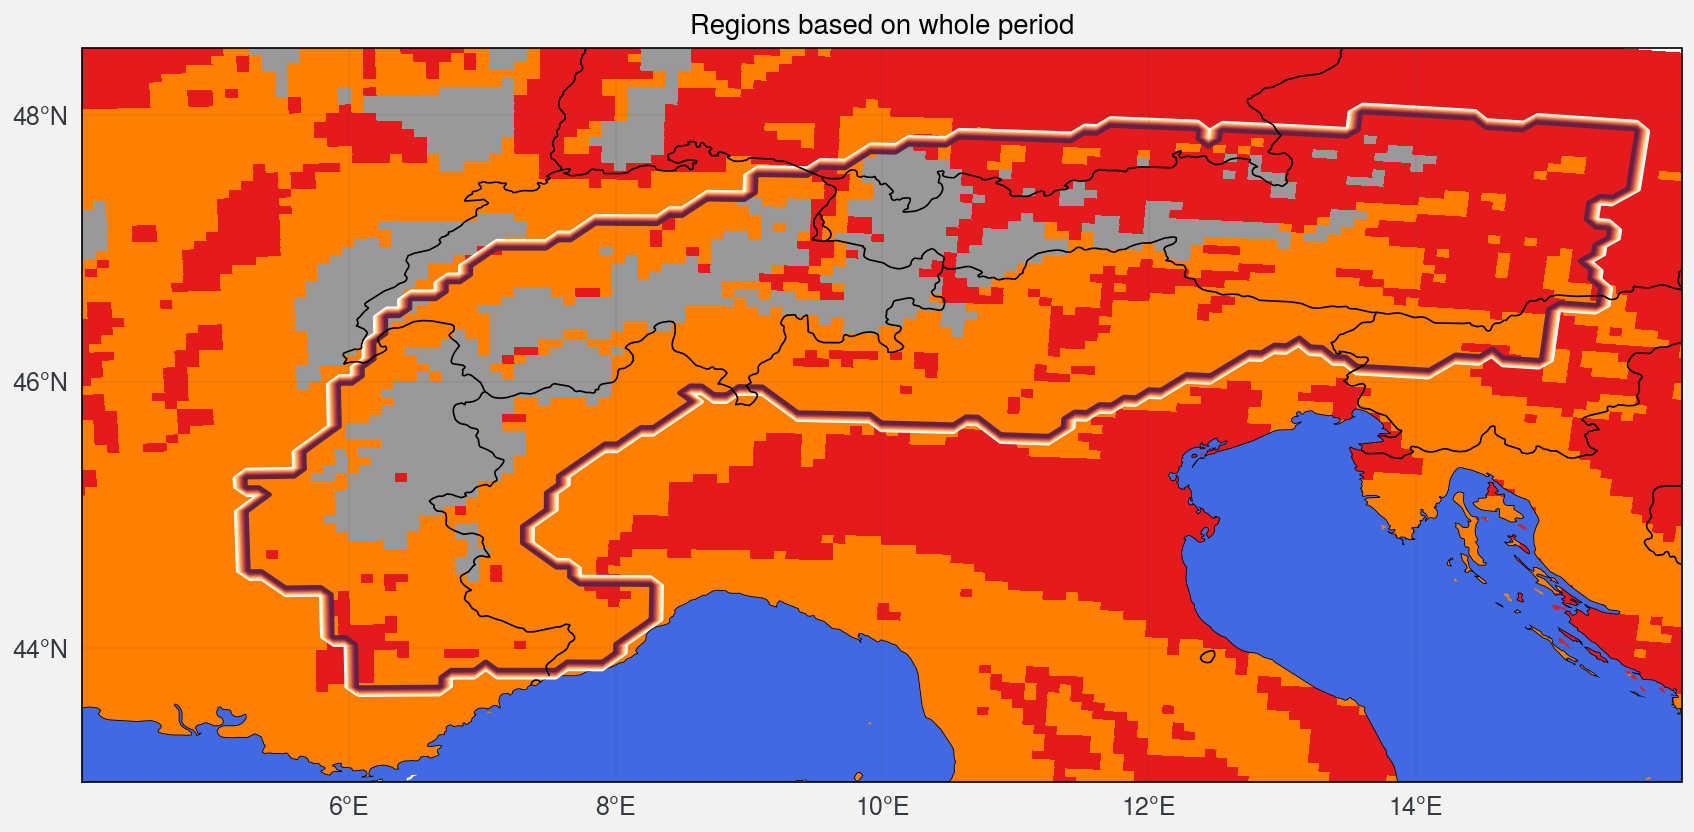

In [8]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)

# Whole period
m=ax.pcolormesh(lon, lat, regions_wp+0.1, levels=3,cmap='Set1')

ax.contour(lon, lat,alps)
ax.format(**normal_format,title='Regions based on whole period')
ax.format(ocean=True,oceancolor='royalblue',reso='hi')

In [9]:
JJAS = (regions_wp == 1)
DJFM = (regions_wp == 3)
AMON = (regions_wp == 2)

alps_JJAS = np.logical_and(alps,JJAS)
alps_DJFM = np.logical_and(alps,DJFM)
alps_AMON = np.logical_and(alps,AMON)

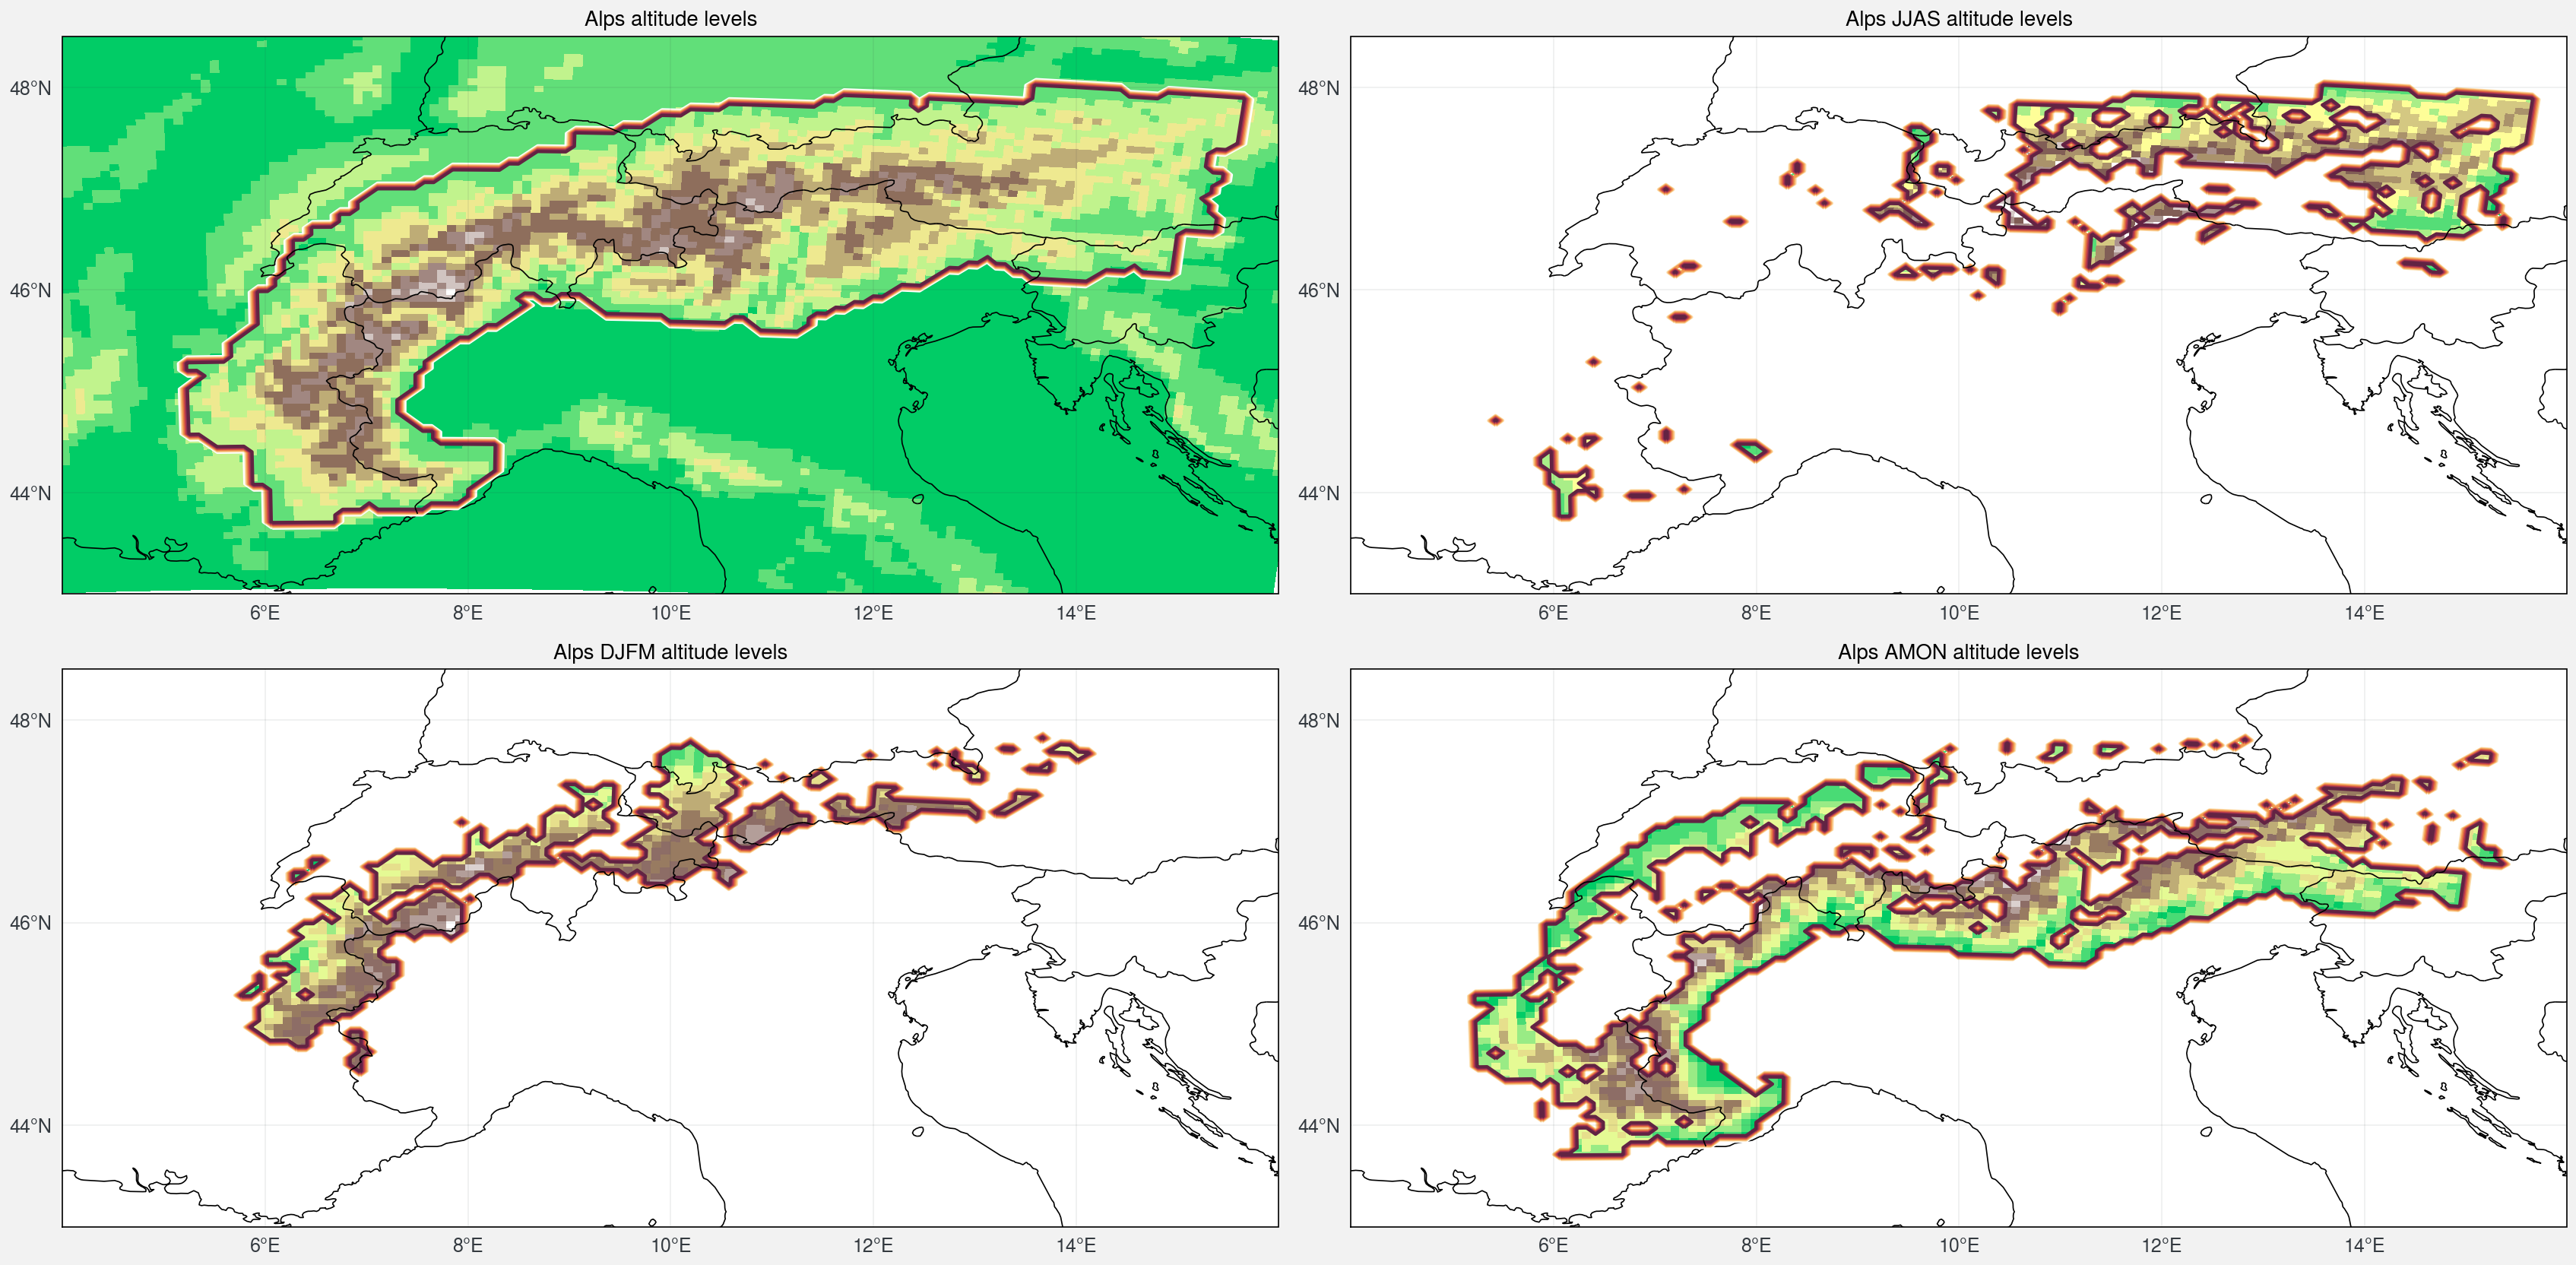

In [10]:
f, axs = pplt.subplots(proj='cyl', axwidth=8, ncols=2,nrows=2)

H_alps_JJAS = np.ma.masked_array(H, mask=np.invert(alps_JJAS))
H_alps_DJFM = np.ma.masked_array(H, mask=np.invert(alps_DJFM))
H_alps_AMON = np.ma.masked_array(H, mask=np.invert(alps_AMON))

axs[0].pcolormesh(lon, lat,H,edgecolors='none',cmap=colors_land)
axs[0].contour(lon, lat,alps)
axs[0].format(**normal_format,title='Alps altitude levels')

axs[1].pcolormesh(lon, lat,H_alps_JJAS,edgecolors='none',cmap=colors_land)
axs[1].contour(lon, lat,alps_JJAS)
axs[1].format(**normal_format,title='Alps JJAS altitude levels')

axs[2].pcolormesh(lon, lat,H_alps_DJFM,edgecolors='none',cmap=colors_land)
axs[2].contour(lon, lat,alps_DJFM)
axs[2].format(**normal_format,title='Alps DJFM altitude levels')

axs[3].pcolormesh(lon, lat,H_alps_AMON,edgecolors='none',cmap=colors_land)
axs[3].contour(lon, lat,alps_AMON)
axs[3].format(**normal_format,title='Alps AMON altitude levels')

#### Kmeans regions

In [7]:
def do_kmeans(data):
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300
    }
    
    # A list holds the SSE values for each k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    
    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

    k = kl.elbow
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    
    return k, kmeans.cluster_centers_, np.reshape(kmeans.labels_,(91,139))

In [8]:
def do_kmeans2(data):
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300
    }
    
    # A list holds the SSE values for each k
    sse = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    
    kl = KneeLocator(range(2, 11), sse, curve="convex", direction="decreasing")

    k = kl.elbow
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    
    return k, kmeans.cluster_centers_, np.reshape(kmeans.labels_,(91,139))

In [9]:
def do_kmeans_givenk(data,k):
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300
    }
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    
    return kmeans.cluster_centers_, np.reshape(kmeans.labels_,(91,139))

In [10]:
TP_month_mean_1990 = TP_month[:30].mean(axis=0)
TP_month_mean_2100 = TP_month[-31:-1].mean(axis=0)

In [10]:
# 1990
mean_TP_1990 = TP_month_mean_1990.mean(axis=0)
norm_TP_month_mean_1990 = TP_month_mean_1990/mean_TP_1990[None,:]
norm_TP_month_mean_1990_reshape = np.reshape(norm_TP_month_mean_1990,(12,12649))
norm_TP_month_mean_1990_reshape_T = np.transpose(norm_TP_month_mean_1990_reshape)

k_1990, clustercenters_1990, labels_1990 = do_kmeans(norm_TP_month_mean_1990_reshape_T)

# 2100
mean_TP_2100 = TP_month_mean_2100.mean(axis=0)
norm_TP_month_mean_2100 = TP_month_mean_2100/mean_TP_2100[None,:]
norm_TP_month_mean_2100_reshape = np.reshape(norm_TP_month_mean_2100,(12,12649))
norm_TP_month_mean_2100_reshape_T = np.transpose(norm_TP_month_mean_2100_reshape)

k_2100, clustercenters_2100, labels_2100 = do_kmeans(norm_TP_month_mean_2100_reshape_T)

# wp
mean_TP_wp = TP_month_mean_wp.mean(axis=0)
norm_TP_month_mean_wp = TP_month_mean_wp/mean_TP_wp[None,:]
norm_TP_month_mean_wp_reshape = np.reshape(norm_TP_month_mean_wp,(12,12649))
norm_TP_month_mean_wp_reshape_T = np.transpose(norm_TP_month_mean_wp_reshape)

k_wp, clustercenters_wp, labels_wp = do_kmeans(norm_TP_month_mean_wp_reshape_T)

In [11]:
print(k_1990,k_2100,k_wp)

4 4 4


(<matplotlib.legend.Legend at 0x7f18218a62b0>,
 <matplotlib.legend.Legend at 0x7f18218dc610>)

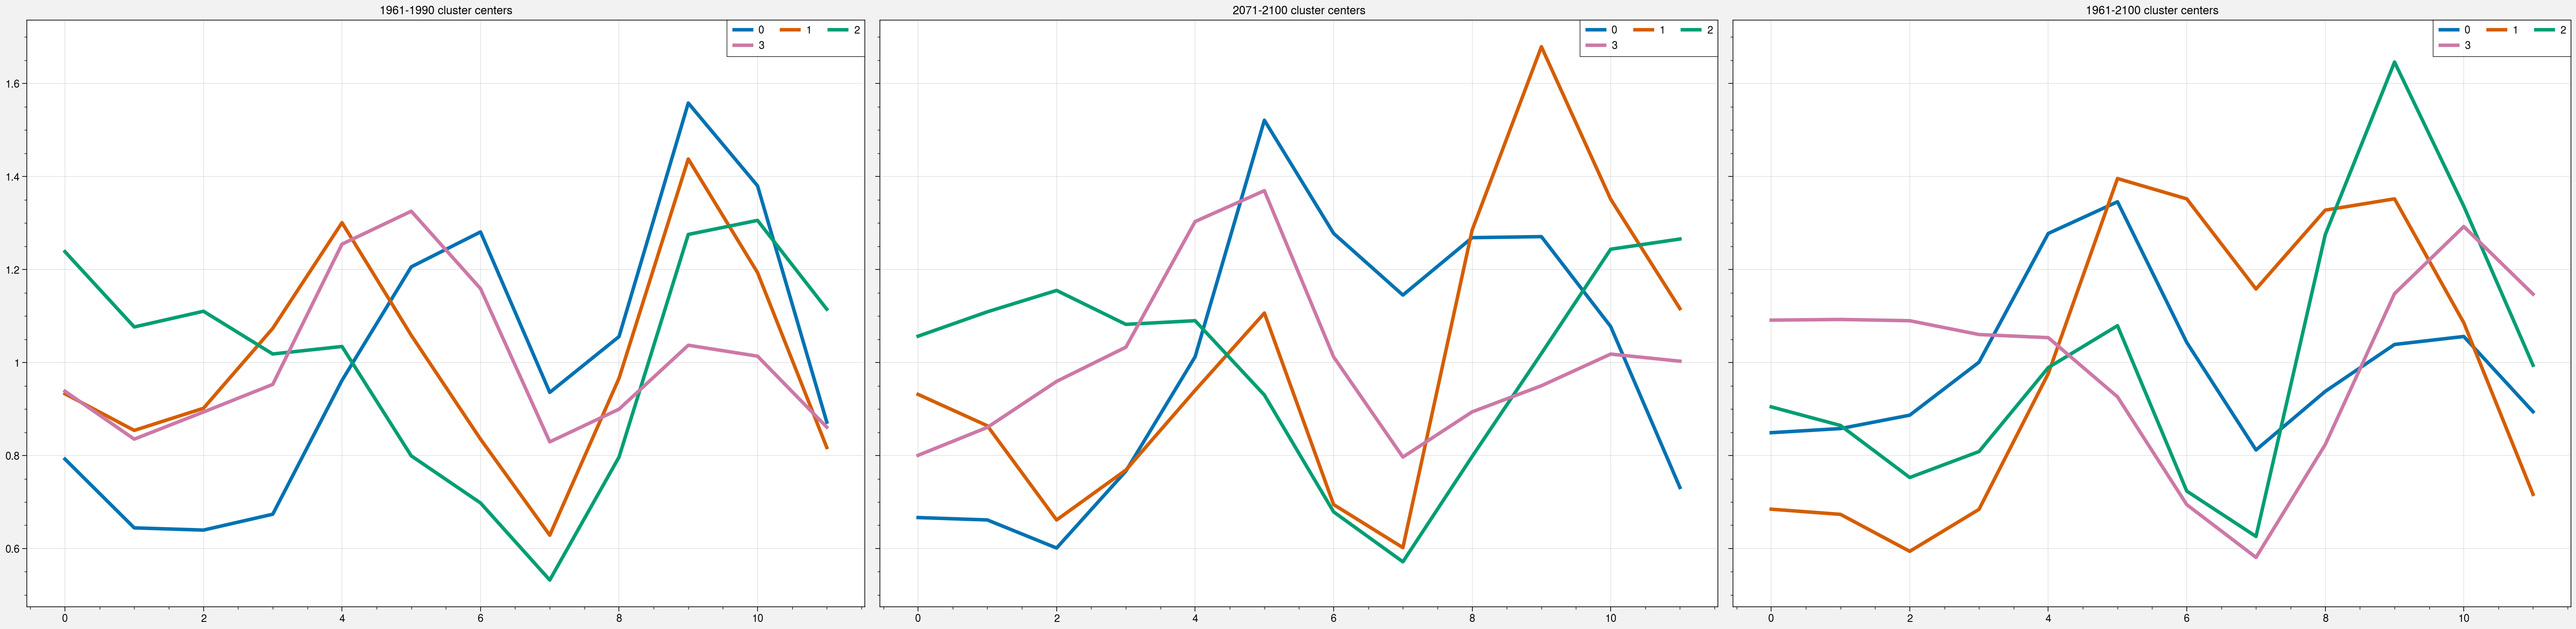

In [13]:
f,axs = pplt.subplots(axheight=7,axwidth=10,ncols=3)

for i in range(k_1990):
    axs[0].plot(clustercenters_1990[i],linewidth=3,label=i)
    axs[0].format(title='1961-1990 cluster centers')

for i in range(k_2100):
    axs[1].plot(clustercenters_2100[i],linewidth=3,label=i)
    axs[1].format(title='2071-2100 cluster centers')

for i in range(k_wp):
    axs[2].plot(clustercenters_wp[i],linewidth=3,label=i)
    axs[2].format(title='1961-2100 cluster centers')

axs.legend()

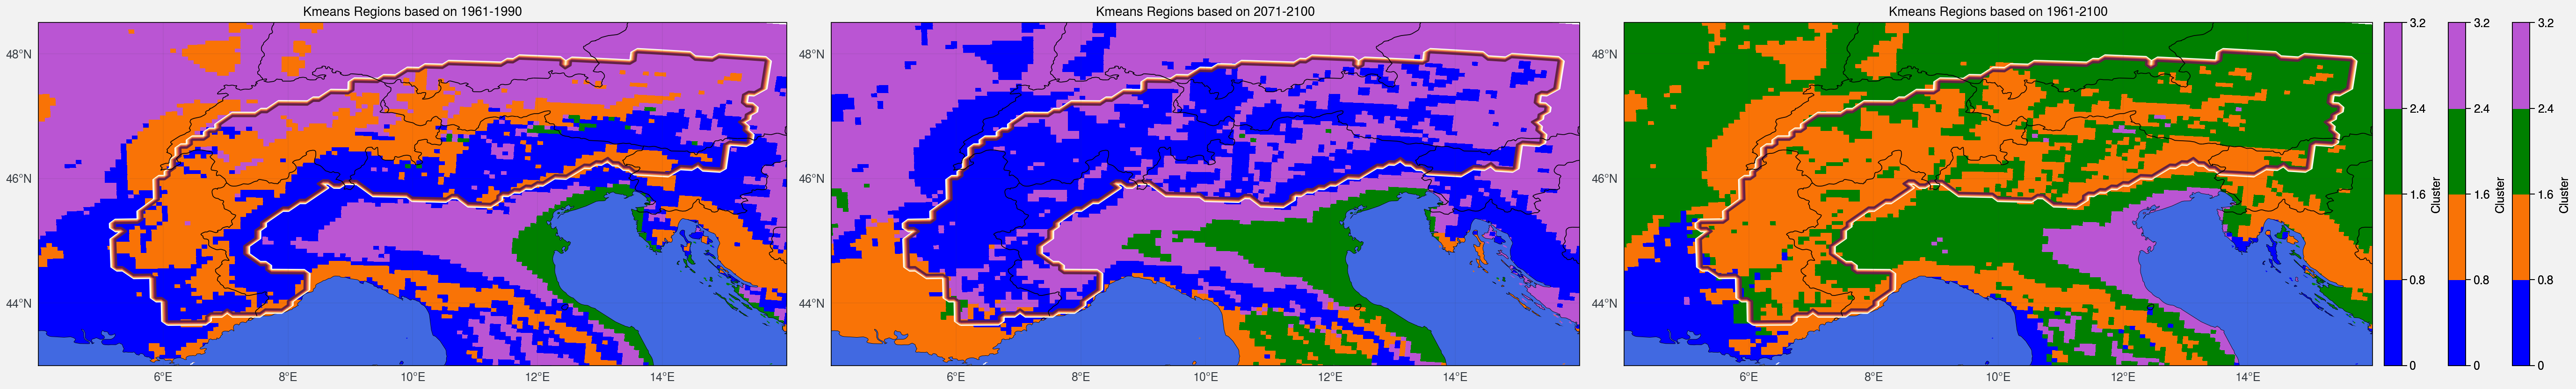

In [18]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=3)

custom_cmap = ["b","orange","g","mediumorchid"]

# Whole period
m=axs[0].pcolormesh(lon, lat, labels_1990+0.1, levels=4,cmap=custom_cmap)
f.colorbar(m,label= 'Cluster')
axs[0].contour(lon, lat,alps)
axs[0].format(**normal_format,title='Kmeans Regions based on 1961-1990')
axs[0].format(ocean=True,oceancolor='royalblue',reso='hi')

m=axs[1].pcolormesh(lon, lat, labels_2100+0.1, levels=4,cmap=custom_cmap)
f.colorbar(m,label= 'Cluster')
axs[1].contour(lon, lat,alps)
axs[1].format(**normal_format,title='Kmeans Regions based on 2071-2100')
axs[1].format(ocean=True,oceancolor='royalblue',reso='hi')

m=axs[2].pcolormesh(lon, lat, labels_wp+0.1, levels=4,cmap=custom_cmap)
f.colorbar(m,label= 'Cluster')
axs[2].contour(lon, lat,alps)
axs[2].format(**normal_format,title='Kmeans Regions based on 1961-2100')
axs[2].format(ocean=True,oceancolor='royalblue',reso='hi')

In [16]:
clustercenters_1990_k5, labels_1990_k5 = do_kmeans_givenk(norm_TP_month_mean_1990_reshape_T, 5)

clustercenters_2100_k5, labels_2100_k5 = do_kmeans_givenk(norm_TP_month_mean_2100_reshape_T, 5)

clustercenters_wp_k5, labels_wp_k5 = do_kmeans_givenk(norm_TP_month_mean_wp_reshape_T, 5)

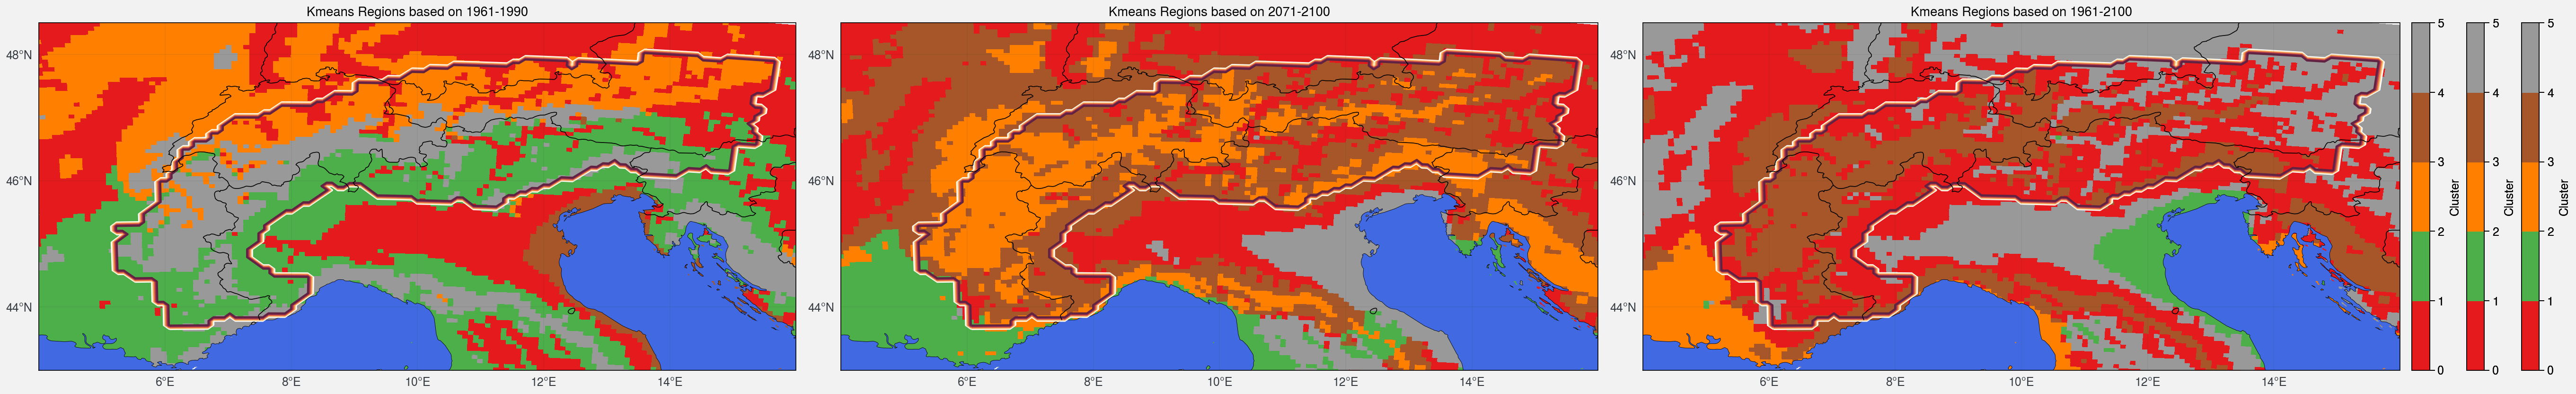

In [22]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=3)

custom_cmap = ["b","orange","g","mediumorchid"]

# Whole period
m=axs[0].pcolormesh(lon, lat, labels_1990_k5+0.1, levels=4,cmap="Set1")
f.colorbar(m,label= 'Cluster')
axs[0].contour(lon, lat,alps)
axs[0].format(**normal_format,title='Kmeans Regions based on 1961-1990')
axs[0].format(ocean=True,oceancolor='royalblue',reso='hi')

m=axs[1].pcolormesh(lon, lat, labels_2100_k5+0.1, levels=4,cmap="Set1")
f.colorbar(m,label= 'Cluster')
axs[1].contour(lon, lat,alps)
axs[1].format(**normal_format,title='Kmeans Regions based on 2071-2100')
axs[1].format(ocean=True,oceancolor='royalblue',reso='hi')

m=axs[2].pcolormesh(lon, lat, labels_wp_k5+0.1, levels=4,cmap="Set1")
f.colorbar(m,label= 'Cluster')
axs[2].contour(lon, lat,alps)
axs[2].format(**normal_format,title='Kmeans Regions based on 1961-2100')
axs[2].format(ocean=True,oceancolor='royalblue',reso='hi')

#### Only Alps

In [12]:
# Alps
alps_months = np.repeat(alps[np.newaxis,:,:],12,axis=0)

TP_month_mean_1990_alps = np.ma.masked_array(TP_month_mean_1990, mask=np.invert(alps_months))
TP_month_mean_2100_alps = np.ma.masked_array(TP_month_mean_2100, mask=np.invert(alps_months))
TP_month_mean_wp_alps = np.ma.masked_array(TP_month_mean_wp, mask=np.invert(alps_months))

# 1990
mean_TP_1990 = TP_month_mean_1990_alps.mean(axis=0)
norm_TP_month_mean_1990 = TP_month_mean_1990_alps/mean_TP_1990[None,:]
norm_TP_month_mean_1990_reshape = np.reshape(norm_TP_month_mean_1990,(12,12649))
norm_TP_month_mean_1990_reshape_T = np.transpose(norm_TP_month_mean_1990_reshape)
norm_TP_month_mean_1990_reshape_T[norm_TP_month_mean_1990_reshape_T.mask] = 0

k_1990, clustercenters_1990, labels_1990 = do_kmeans2(norm_TP_month_mean_1990_reshape_T)

# 2100
mean_TP_2100 = TP_month_mean_2100_alps.mean(axis=0)
norm_TP_month_mean_2100 = TP_month_mean_2100_alps/mean_TP_2100[None,:]
norm_TP_month_mean_2100_reshape = np.reshape(norm_TP_month_mean_2100,(12,12649))
norm_TP_month_mean_2100_reshape_T = np.transpose(norm_TP_month_mean_2100_reshape)
norm_TP_month_mean_2100_reshape_T[norm_TP_month_mean_2100_reshape_T.mask] = 0

k_2100, clustercenters_2100, labels_2100 = do_kmeans2(norm_TP_month_mean_2100_reshape_T)

# wp
mean_TP_wp = TP_month_mean_wp_alps.mean(axis=0)
norm_TP_month_mean_wp = TP_month_mean_wp_alps/mean_TP_wp[None,:]
norm_TP_month_mean_wp_reshape = np.reshape(norm_TP_month_mean_wp,(12,12649))
norm_TP_month_mean_wp_reshape_T = np.transpose(norm_TP_month_mean_wp_reshape)
norm_TP_month_mean_wp_reshape_T[norm_TP_month_mean_wp_reshape_T.mask] = 0

k_wp, clustercenters_wp, labels_wp = do_kmeans2(norm_TP_month_mean_wp_reshape_T)

/tmp/ipykernel_571114/3996784144.py:15: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.legend()


(<matplotlib.legend.Legend at 0x7f387a472590>,
 <matplotlib.legend.Legend at 0x7f387a2ed090>)

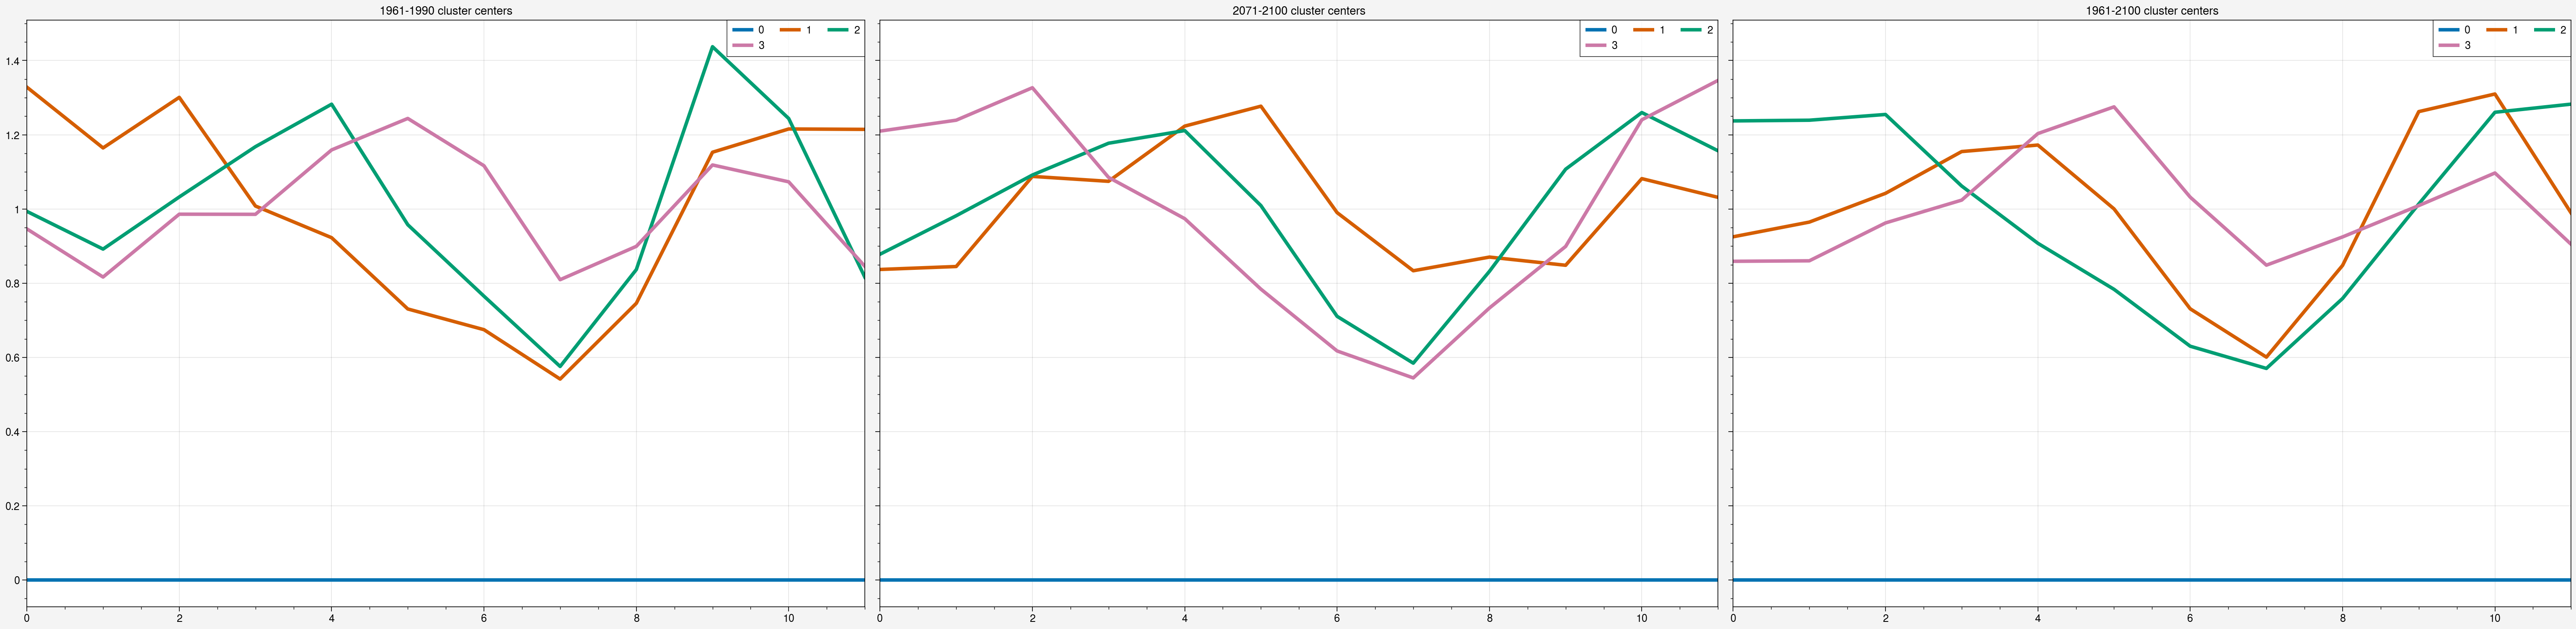

In [14]:
f,axs = pplt.subplots(axheight=7,axwidth=10,ncols=3)

for i in range(k_1990):
    axs[0].plot(clustercenters_1990[i],linewidth=3,label=i)
    axs[0].format(title='1961-1990 cluster centers')

for i in range(k_2100):
    axs[1].plot(clustercenters_2100[i],linewidth=3,label=i)
    axs[1].format(title='2071-2100 cluster centers')

for i in range(k_wp):
    axs[2].plot(clustercenters_wp[i],linewidth=3,label=i)
    axs[2].format(title='1961-2100 cluster centers')

axs.legend()

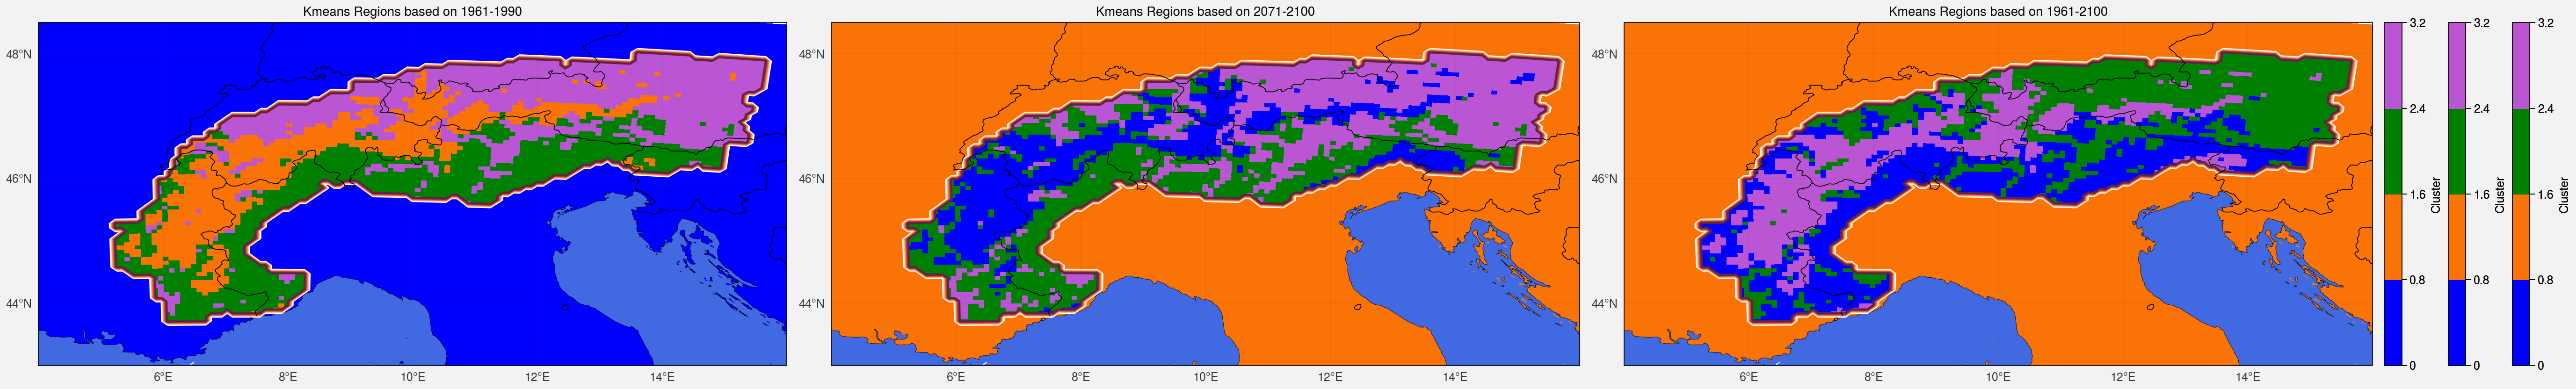

In [18]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=3)

custom_cmap = ["b","orange","g","mediumorchid"]

# Whole period
m=axs[0].pcolormesh(lon, lat, labels_1990+0.1, levels=4,cmap=custom_cmap)
f.colorbar(m,label= 'Cluster')
axs[0].contour(lon, lat,alps)
axs[0].format(**normal_format,title='Kmeans Regions based on 1961-1990')
axs[0].format(ocean=True,oceancolor='royalblue',reso='hi')

m=axs[1].pcolormesh(lon, lat, labels_2100+0.1, levels=4,cmap=custom_cmap)
f.colorbar(m,label= 'Cluster')
axs[1].contour(lon, lat,alps)
axs[1].format(**normal_format,title='Kmeans Regions based on 2071-2100')
axs[1].format(ocean=True,oceancolor='royalblue',reso='hi')

m=axs[2].pcolormesh(lon, lat, labels_wp+0.1, levels=4,cmap=custom_cmap)
f.colorbar(m,label= 'Cluster')
axs[2].contour(lon, lat,alps)
axs[2].format(**normal_format,title='Kmeans Regions based on 1961-2100')
axs[2].format(ocean=True,oceancolor='royalblue',reso='hi')